Import Required Libraries for EDA

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry
sns.set_style("whitegrid")
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.subplots as sp
import plotly.graph_objects as go

Load the Dataset

In [2]:
original_data_file = pd.read_excel("Kickstarter.xlsx")

Pre-processing Steps

In [3]:
df = original_data_file.copy()

#Function to convert country codes to country name
def get_country_name(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except AttributeError:
        return "Unknown"


#1. Drop Columns that have no impact on prediction
df = df.drop(columns=['id','name'], axis=1)

#2. Drop Columns that can only be determined after knowing the state of the project
cols_unknown_at_launch = columns_to_drop = ['pledged', 'state_changed_at', 'backers_count', 'usd_pledged',
                   'state_changed_at_weekday', 'state_changed_at_month',
                   'state_changed_at_day', 'state_changed_at_yr',
                   'state_changed_at_hr', 'launch_to_state_change_days', 'spotlight', 'staff_pick']

df = df.drop(columns=cols_unknown_at_launch, axis=1)

#3. Drop Columns with repeated information in other columns:
cols_repeat_info = ['currency', 'deadline', 'created_at', 'launched_at']
df = df.drop(columns=cols_repeat_info, axis=1)

#4. Remove rows with state other than successful or failed
df = df[df['state'].isin(['successful', 'failed'])]

#5. Create new column to convert goal to USD and drop goal, rate column
df['goal_usd'] = df['goal'] * df['static_usd_rate']
df = df.drop(columns=['goal', 'static_usd_rate'], axis=1)

#6. Convert country to full name for easier interpretation
df['country'] = df['country'].apply(lambda x: get_country_name(x))

# Pre-processing Steps added after EDA

#7. Replace missing values in category column with Others (assuming these projects were not assigned a category)
df['category'] = df['category'].fillna('Others')

#8. Remove disable_communication column as it has only 1 value, so cannot contribute to prediction
df = df.drop(columns=['disable_communication'], axis=1)

#9. Convert all categorical columns to category type
categorical_cols = ['state', 'country', 'category',
                    'deadline_weekday', 'created_at_weekday', 'launched_at_weekday', 
                    'deadline_month', 'deadline_day', 'deadline_yr', 'deadline_hr', 
                    'created_at_month', 'created_at_day', 'created_at_yr', 
                    'created_at_hr', 'launched_at_month', 'launched_at_day', 
                    'launched_at_yr', 'launched_at_hr']

numerical_cols = df.columns.difference(categorical_cols)

df[categorical_cols] = df[categorical_cols].astype('category')

Dataset Info

Insights - Missing values only in category column, data types are correct for all fields

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13435 entries, 0 to 15473
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   state                    13435 non-null  category
 1   country                  13435 non-null  category
 2   staff_pick               13435 non-null  category
 3   category                 13435 non-null  category
 4   spotlight                13435 non-null  category
 5   name_len                 13435 non-null  float64 
 6   name_len_clean           13435 non-null  float64 
 7   blurb_len                13435 non-null  float64 
 8   blurb_len_clean          13435 non-null  float64 
 9   deadline_weekday         13435 non-null  category
 10  created_at_weekday       13435 non-null  category
 11  launched_at_weekday      13435 non-null  category
 12  deadline_month           13435 non-null  category
 13  deadline_day             13435 non-null  category
 14  deadli

Duplicated Rows

Insight - No Duplicated Rows in the dataset

In [9]:
df.duplicated().sum()

0

Dataset describe for numeric columns

In [10]:
df.describe()

,name_len,name_len_clean,blurb_len,blurb_len_clean,create_to_launch_days,launch_to_deadline_days,goal_usd
count,13435.000000,13435.000000,13435.000000,13435.000000,13435.000000,13435.000000,1.343500e+04
mean,5.804466,5.147897,19.061035,13.069967,46.746185,34.445032,9.107229e+04
std,2.835594,2.413875,4.545389,3.177685,101.006404,11.936018,1.520810e+06
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000e+00
25%,3.000000,3.000000,17.000000,11.000000,4.000000,30.000000,3.500000e+03
50%,6.000000,5.000000,20.000000,13.000000,14.000000,30.000000,1.109928e+04
75%,8.000000,7.000000,22.000000,15.000000,43.000000,39.000000,3.999950e+04
max,16.000000,14.000000,35.000000,30.000000,1528.000000,91.000000,1.000000e+08


Dataset describe for categorical columns

In [11]:
df.describe(include='category')

,state,country,staff_pick,category,spotlight,deadline_weekday,created_at_weekday,launched_at_weekday,deadline_month,deadline_day,deadline_yr,deadline_hr,created_at_month,created_at_day,created_at_yr,created_at_hr,launched_at_month,launched_at_day,launched_at_yr,launched_at_hr
count,13435,13435,13435,13435,13435,13435,13435,13435,13435,13435,13435,13435,13435,13435,13435,13435,13435,13435,13435,13435
unique,2,18,2,23,2,7,7,7,12,31,8,24,12,31,8,24,12,31,8,24
top,failed,United States,False,Hardware,False,Friday,Tuesday,Tuesday,8,1,2015,11,7,8,2015,15,7,2,2015,11
freq,8860,9603,11729,2348,8860,2433,2314,2946,1350,571,6295,932,1504,502,5700,923,1389,501,6225,1008


### Exploring Categorical Variables

1. Category Distribution

In [12]:
fig = px.histogram(df, x='category', 
                   title='Category Distribution',
                   color_discrete_sequence=['#3498db'],
                   )

fig.update_traces(marker=dict(line=dict(width=2, color='DarkSlateGrey')))

# format the layout
fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(zeroline=False, gridcolor='white'),
    paper_bgcolor='rgb(233,233,233)',
    plot_bgcolor='rgb(233,233,233)',
)

fig.show()

Country Distribution

In [13]:
fig = px.histogram(df, x='country', 
                   title='Country Distribution',
                   color_discrete_sequence=['#3498db'],  
                   )

fig.update_traces(marker=dict(line=dict(width=2, color='DarkSlateGrey')))

# format the layout
fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(zeroline=False, gridcolor='white'),
    paper_bgcolor='rgb(233,233,233)',
    plot_bgcolor='rgb(233,233,233)',
)

fig.show()

Project State Distribution

In [15]:
fig = px.pie(df, names='state', 
             title='Project State Distribution',
             color_discrete_sequence=['#ff7f0e', '#3498db'],# Setting custom color
            )

# format the layout
fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(zeroline=False, gridcolor='white'),
    paper_bgcolor='rgb(233,233,233)',
    plot_bgcolor='rgb(233,233,233)',
)

fig.update_traces(marker=dict(line=dict(width=2, color='DarkSlateGrey')))
# Show the pie chart
fig.show()

### Exploring Numerical Variables

1. Boxplots for each numerical predictor

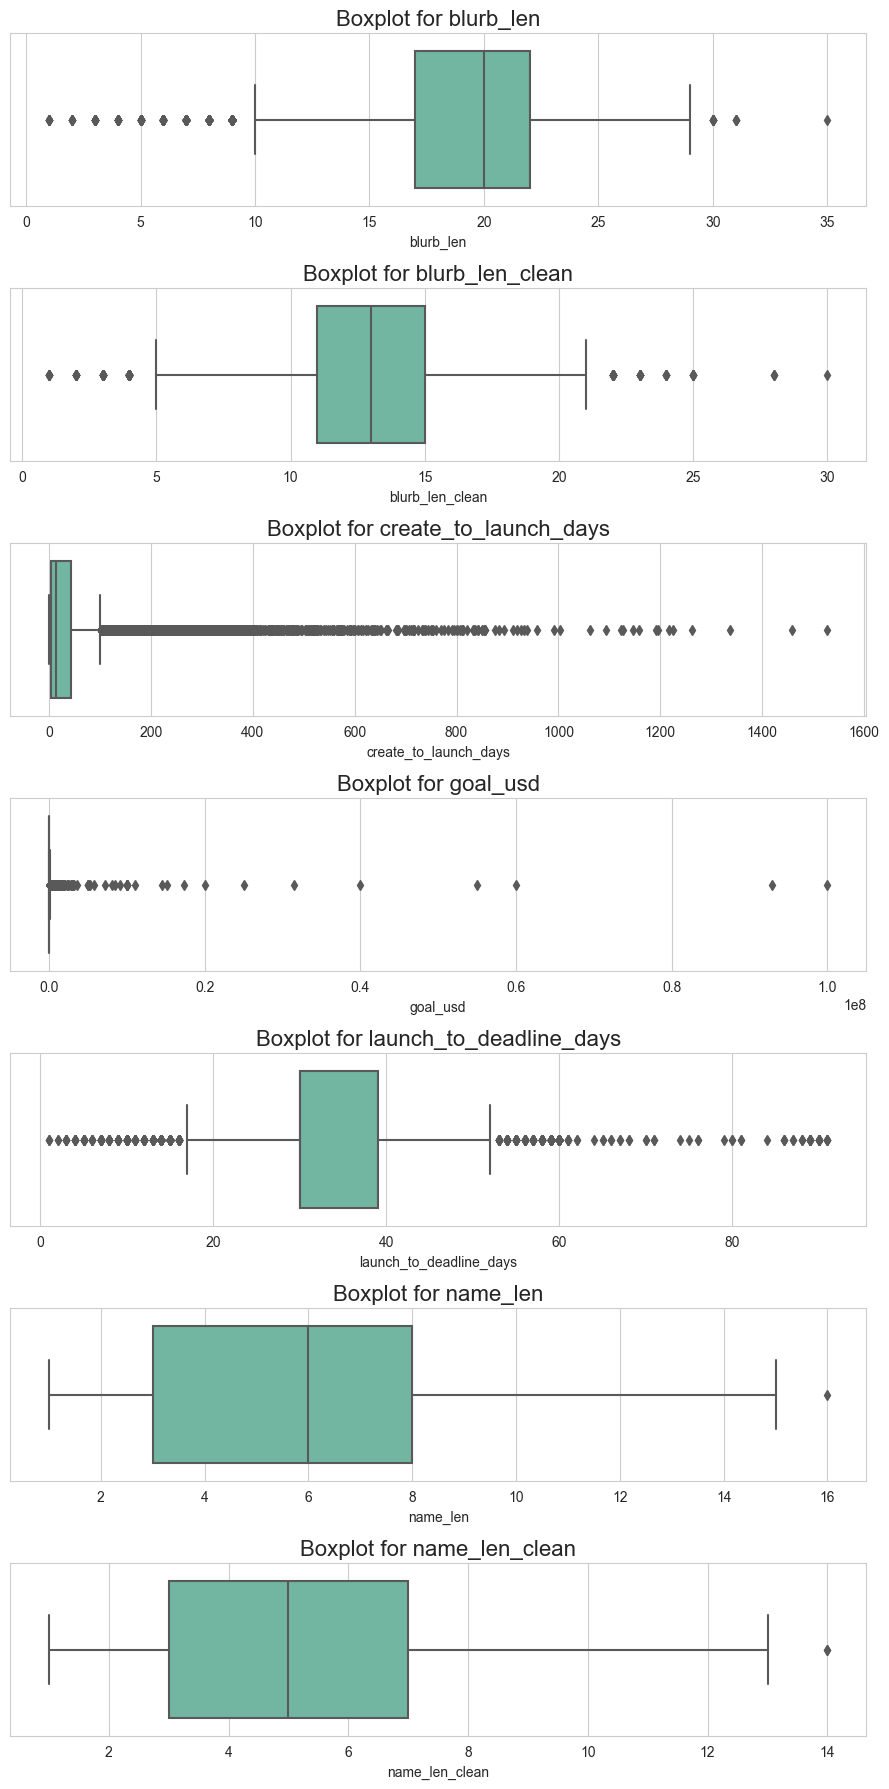

In [16]:
fig, axes = plt.subplots(len(numerical_cols), 1, figsize=(9, 18))

#Looping through the subplots and create countplots for each feature
for i, ax in enumerate(axes.flat):
    if i < len(numerical_cols):
        sns.boxplot(data=df, x=numerical_cols[i], ax=ax, palette='Set2', orient='h')
        ax.set_title(f'Boxplot for {numerical_cols[i]}', fontsize=16)
        
# Adjusting the layout for better visualization
plt.tight_layout()

plt.show()

See which categories are more successful

In [17]:
# Get top 10 categories in ascending order
top_categories = df['category'].value_counts().head(10).index

# Filter dataframe for top 10 categories
filtered_df = df[df['category'].isin(top_categories)]

# Filter data for successful and failed projects
successful_df = filtered_df[filtered_df['state'] == 'successful']
failed_df = filtered_df[filtered_df['state'] == 'failed']

# Count main categories for successful and failed projects
successful_category_counts = successful_df['category'].value_counts().sort_values(ascending=False)
failed_category_counts = failed_df['category'].value_counts().sort_values(ascending=False)

# Create subplots with 1 row and 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=['Successful Projects', 'Failed Projects'])

# Add bar plot for successful projects
fig.add_trace(go.Bar(x=successful_category_counts.index, y=successful_category_counts.values, 
                     marker_color='#3498db', name='Successful Projects'), row=1, col=1)

# Add bar plot for failed projects
fig.add_trace(go.Bar(x=failed_category_counts.index, y=failed_category_counts.values, 
                     marker_color='#ff7f0e', name='Failed Projects'), row=1, col=2)

fig.update_traces(marker=dict(line=dict(width=2, color='DarkSlateGrey')))

# Update layout
fig.update_layout(title_text='Distribution of Top 10 Categories by Project State',
                  xaxis=dict(showgrid=False, zeroline=False),
                  yaxis=dict(showgrid=True, zeroline=False),
                  paper_bgcolor='rgb(233,233,233)',
                  plot_bgcolor='rgb(233,233,233)',
                  showlegend=False)

# Show the subplot
fig.show()

Plot the relationship between project funding goal and project state

In [18]:
fig = px.box(df, x='state', y='goal_usd', color='state',
                 title='Relationship between Project State and Funding Goal',
                 color_discrete_sequence=['#ff7f0e', '#3498db'],
                 labels={'state': 'Project State', 'goal_usd': 'Funding Goal'},
                 template='plotly_white')

fig.update_traces(marker=dict(line=dict(width=2, color='DarkSlateGrey')))

# format the layout
fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(zeroline=False, gridcolor='white'),
    paper_bgcolor='rgb(233,233,233)',
    plot_bgcolor='rgb(233,233,233)',
)

# Show the scatter plot
fig.show()

Plot the relationship between project country and project state

In [19]:
fig = px.histogram(df, x='country', color='state',
             title='Success and Failure Rates by Country',
             labels={'country': 'Country', 'state': 'Project State'},
             template='plotly_white', barmode='group',
             color_discrete_sequence=['#ff7f0e', '#3498db']
            )

# Customizing marker appearance
fig.update_traces(marker=dict(line=dict(width=2, color='DarkSlateGrey')))

# format the layout
fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(zeroline=False, gridcolor='white'),
    paper_bgcolor='rgb(233,233,233)',
    plot_bgcolor='rgb(233,233,233)',
)

# Show the plot
fig.show()

Yearly Trend of Success Rate

In [20]:
yearly_state_counts = df.groupby(['launched_at_yr', 'state']).size().unstack(fill_value=0)
yearly_state_counts['success_rate'] = yearly_state_counts['successful'] / (yearly_state_counts['successful'] + yearly_state_counts['failed'])

# Creating a line plot for success rate and failure rate over the years
fig = px.line(yearly_state_counts, x=yearly_state_counts.index, y='success_rate',
              title='Success and Failure Rates of Projects Over the Years',
              color_discrete_sequence=['#1f77b4'])

# format the layout
fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(zeroline=False, gridcolor='white'),
    paper_bgcolor='rgb(233,233,233)',
    plot_bgcolor='rgb(233,233,233)',
)

# Show the plot
fig.show()

Monthly Trend of Success Rate

In [21]:
monthly_state_counts = df.groupby(['launched_at_month', 'state']).size().unstack(fill_value=0)
monthly_state_counts['success_rate'] = monthly_state_counts['successful'] / (monthly_state_counts['successful'] + monthly_state_counts['failed'])

# Creating a line plot for success rate and failure rate over the years
fig = px.line(monthly_state_counts, x=monthly_state_counts.index, y='success_rate',
              title='Success and Failure Rates of Projects Over the Months',
              color_discrete_sequence=['#1f77b4'])

# format the layout
fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(zeroline=False, gridcolor='white'),
    paper_bgcolor='rgb(233,233,233)',
    plot_bgcolor='rgb(233,233,233)',
)

# Show the plot
fig.show()

Day of the month wise trend of success rates

In [22]:
daily_state_counts = df.groupby(['launched_at_day', 'state']).size().unstack(fill_value=0)
daily_state_counts['success_rate'] = daily_state_counts['successful'] / (daily_state_counts['successful'] + daily_state_counts['failed'])

# Creating a line plot for success rate and failure rate over the years
fig = px.line(daily_state_counts, x=daily_state_counts.index, y='success_rate',
              title='Success and Failure Rates of Projects Over the Days',
              color_discrete_sequence=['#1f77b4'])

# format the layout
fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(zeroline=False, gridcolor='white'),
    paper_bgcolor='rgb(233,233,233)',
    plot_bgcolor='rgb(233,233,233)',
)

# Show the plot
fig.show()

Weekday wise trend of Success Rates

In [25]:
daily_state_counts = df.groupby(['launched_at_weekday', 'state']).size().unstack(fill_value=0)
daily_state_counts['success_rate'] = daily_state_counts['successful'] / (daily_state_counts['successful'] + daily_state_counts['failed'])

# Creating a line plot for success rate and failure rate over the years
fig = px.line(daily_state_counts, x=daily_state_counts.index, y='success_rate',
              title='Success and Failure Rates of Projects Over the Day of the week',
              color_discrete_sequence=['#1f77b4'])

# format the layout
fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(zeroline=False, gridcolor='white'),
    paper_bgcolor='rgb(233,233,233)',
    plot_bgcolor='rgb(233,233,233)',
)

# Show the plot
fig.show()

Project created Hour of the day wise trend of Success Rates

In [51]:
daily_state_counts = df.groupby(['launched_at_hr', 'state']).size().unstack(fill_value=0)
daily_state_counts['success_rate'] = daily_state_counts['successful'] / (daily_state_counts['successful'] + daily_state_counts['failed'])

# Creating a line plot for success rate and failure rate over the years
fig = px.line(daily_state_counts, x=daily_state_counts.index, y='success_rate',
              title='Success and Failure Rates of Projects Over the Created Hour of the day',
              color_discrete_sequence=['#1f77b4'])

# format the layout
fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(zeroline=False, gridcolor='white'),
    paper_bgcolor='rgb(233,233,233)',
    plot_bgcolor='rgb(233,233,233)',
)

# Show the plot
fig.show()

Project deadline Hour of the day wise trend of Success Rates

In [52]:
daily_state_counts = df.groupby(['deadline_hr', 'state']).size().unstack(fill_value=0)
daily_state_counts['success_rate'] = daily_state_counts['successful'] / (daily_state_counts['successful'] + daily_state_counts['failed'])

# Creating a line plot for success rate and failure rate over the years
fig = px.line(daily_state_counts, x=daily_state_counts.index, y='success_rate',
              title='Success and Failure Rates of Projects Over the Deadline Hour of the day',
              color_discrete_sequence=['#1f77b4'])

# format the layout
fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(zeroline=False, gridcolor='white'),
    paper_bgcolor='rgb(233,233,233)',
    plot_bgcolor='rgb(233,233,233)',
)

# Show the plot
fig.show()

Relationship between project create to launch duration and success rate

In [23]:
# Calculate success rate for different project durations
duration_success_rate = df.groupby('create_to_launch_days')['state'].apply(lambda x: (x == 'successful').mean()).reset_index()
duration_success_rate.columns = ['create_to_launch_days', 'Success Rate']

# Create a scatter plot for project duration vs. success rate
fig = px.scatter(duration_success_rate, x='create_to_launch_days', y='Success Rate',
                 title='Impact of Create to Launch Duration on Success Rate',
                 labels={'Create to Launch Duration (days)': 'Create to Launch Duration (days)', 'Success Rate': 'Success Rate'},
                 color_discrete_sequence=['#1f77b4']
                )

# Customizing marker appearance
fig.update_traces(marker=dict(line=dict(width=2, color='DarkSlateGrey')))

# format the layout
fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(zeroline=False, gridcolor='white'),
    paper_bgcolor='rgb(233,233,233)',
    plot_bgcolor='rgb(233,233,233)',
)

# Show the plot
fig.show()

Relationship between project launch to deadline duration and success rate

In [24]:
# Calculate success rate for different project durations
duration_success_rate = df.groupby('launch_to_deadline_days')['state'].apply(lambda x: (x == 'successful').mean()).reset_index()
duration_success_rate.columns = ['launch_to_deadline_days', 'Success Rate']

# Create a scatter plot for project duration vs. success rate
fig = px.scatter(duration_success_rate, x='launch_to_deadline_days', y='Success Rate',
                 title='Impact of Launch to Deadline Duration on Success Rate',
                 labels={'Launch to Deadline Duration (days)': 'Launch to Deadline Duration (days)', 'Success Rate': 'Success Rate'},
                 color_discrete_sequence=['#1f77b4']
                )

# Customizing marker appearance
fig.update_traces(marker=dict(line=dict(width=2, color='DarkSlateGrey')))

# format the layout
fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(zeroline=False, gridcolor='white'),
    paper_bgcolor='rgb(233,233,233)',
    plot_bgcolor='rgb(233,233,233)',
)

# Show the plot
fig.show()

Relationship between length of project name and success rate

In [28]:
# Calculate success rate for different project durations
duration_success_rate = df.groupby('name_len')['state'].apply(lambda x: (x == 'successful').mean()).reset_index()
duration_success_rate.columns = ['name_len', 'Success Rate']

fig = px.scatter(duration_success_rate, x='name_len', y='Success Rate',
                 title='Length of Project Name vs. Success Rate',
                 labels={'Length of Project Name': 'Length of Project Name', 'Success Rate': 'Success Rate'},
                 color_discrete_sequence=['#1f77b4']
                )

# Customizing marker appearance
fig.update_traces(marker=dict(line=dict(width=2, color='DarkSlateGrey')))

# format the layout
fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(zeroline=False, gridcolor='white'),
    paper_bgcolor='rgb(233,233,233)',
    plot_bgcolor='rgb(233,233,233)',
)

# Show the plot
fig.show()

In [29]:
# Calculate success rate for different project durations
duration_success_rate = df.groupby('name_len_clean')['state'].apply(lambda x: (x == 'successful').mean()).reset_index()
duration_success_rate.columns = ['name_len_clean', 'Success Rate']

fig = px.scatter(duration_success_rate, x='name_len_clean', y='Success Rate',
                 title='Length of Project Name (cleaned) vs. Success Rate',
                 labels={'Length of Project Name (cleaned)': 'Length of Project Name (cleaned)', 'Success Rate': 'Success Rate'},
                 color_discrete_sequence=['#1f77b4']
                )

# Customizing marker appearance
fig.update_traces(marker=dict(line=dict(width=2, color='DarkSlateGrey')))

# format the layout
fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(zeroline=False, gridcolor='white'),
    paper_bgcolor='rgb(233,233,233)',
    plot_bgcolor='rgb(233,233,233)',
)

# Show the plot
fig.show()

Relationship between length of project blurb and success rate

In [30]:
# Calculate success rate for different project durations
duration_success_rate = df.groupby('blurb_len_clean')['state'].apply(lambda x: (x == 'successful').mean()).reset_index()
duration_success_rate.columns = ['blurb_len_clean', 'Success Rate']

fig = px.scatter(duration_success_rate, x='blurb_len_clean', y='Success Rate',
                 title='Length of Project blurb (cleaned) vs. Success Rate',
                 labels={'Length of Project blurb (cleaned)': 'Length of Project blurb (cleaned)', 'Success Rate': 'Success Rate'},
                 color_discrete_sequence=['#1f77b4']
                )

# Customizing marker appearance
fig.update_traces(marker=dict(line=dict(width=2, color='DarkSlateGrey')))

# format the layout
fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(zeroline=False, gridcolor='white'),
    paper_bgcolor='rgb(233,233,233)',
    plot_bgcolor='rgb(233,233,233)',
)

# Show the plot
fig.show()

Relationship between staff pick and project success

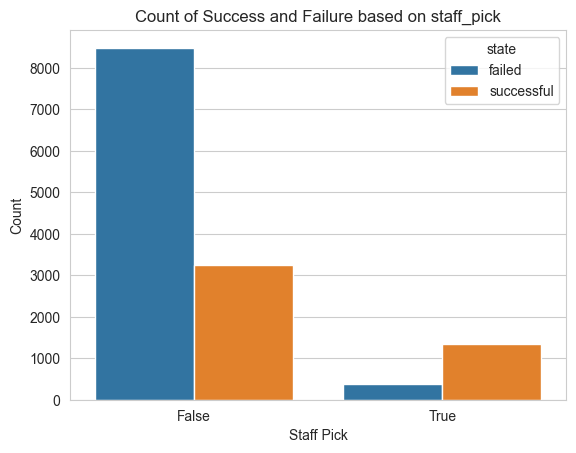

In [31]:
sns.countplot(data=df, x='staff_pick', hue='state')
plt.title('Count of Success and Failure based on staff_pick')
plt.xlabel('Staff Pick')
plt.ylabel('Count')
plt.show()

Relationship between spotlight and project success

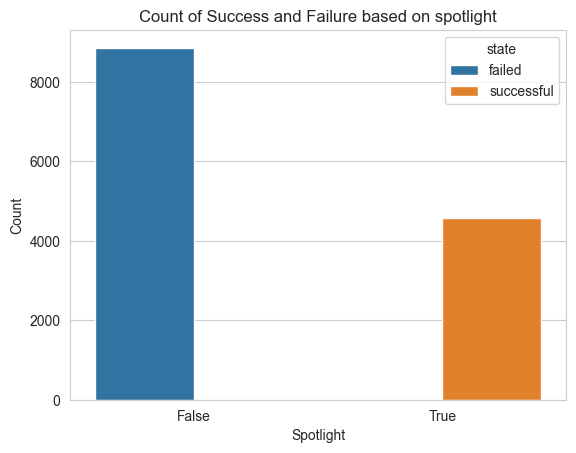

In [32]:
sns.countplot(data=df, x='spotlight', hue='state')
plt.title('Count of Success and Failure based on spotlight')
plt.xlabel('Spotlight')
plt.ylabel('Count')
plt.show()

Create Correlation Matrix with heatmap

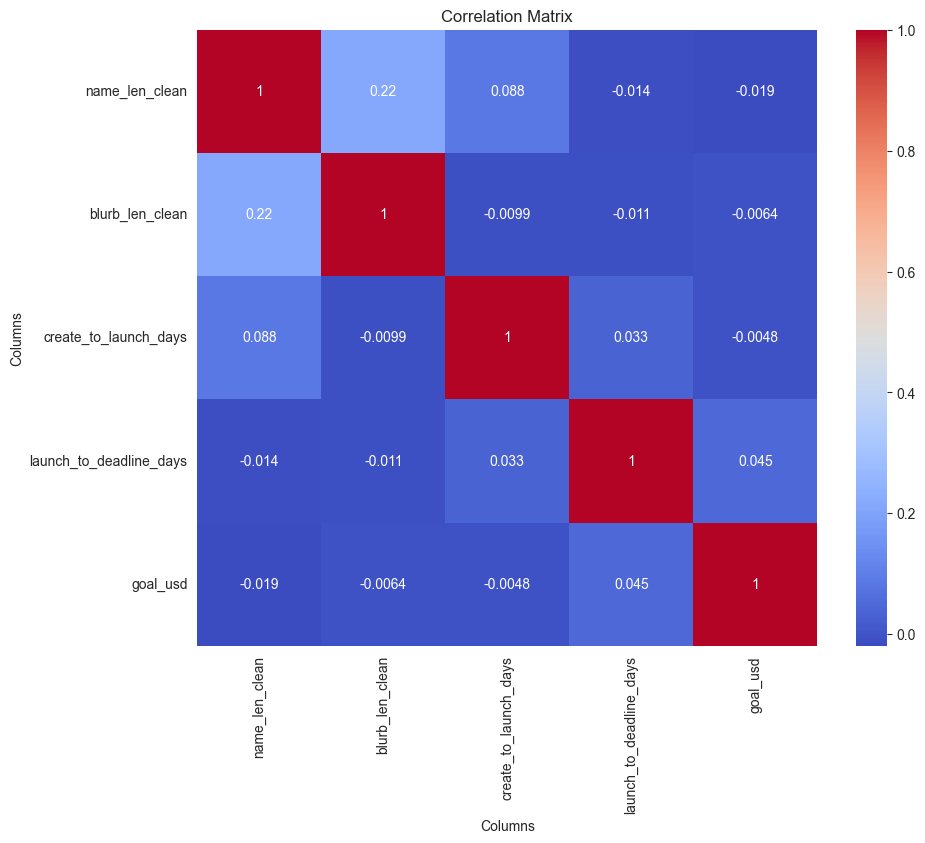

In [49]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Set the title and labels
plt.title('Correlation Matrix')
plt.xlabel('Columns')
plt.ylabel('Columns')

# Show the plot
plt.show()


In [43]:
#Remove cols which are correlated

corr_cols_remove = ['name_len','blurb_len']
df = df.drop(columns=corr_cols_remove, axis=1)

VIF numbers for predictors

In [48]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe with the predictors
new_numerical_cols = numerical_cols.difference(corr_cols_remove)
predictors = df[new_numerical_cols]

# Calculate the VIF for each predictor
vif = pd.DataFrame()
vif["Predictor"] = predictors.columns
vif["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]

# Print the VIF values
print(vif)

                 Predictor       VIF
0          blurb_len_clean  9.357717
1    create_to_launch_days  1.222750
2                 goal_usd  1.005996
3  launch_to_deadline_days  6.519245
4           name_len_clean  5.533187


Check Feature Importance Scores for Predictors

In [11]:
X = df.drop(['state'], axis=1)
y = df['state']

X_encoded = pd.get_dummies(X, columns=categorical_cols)

y = y.map({'successful':1, 'failed':0})

from sklearn.ensemble import RandomForestRegressor
randomforest = RandomForestRegressor(random_state=0)
model = randomforest.fit(X_encoded, y)

feature_imp_df = pd.DataFrame(list(zip(X_encoded.columns,model.feature_importances_)), columns = ['predictor','feature importance'])
# Can specify a threshold for the feature importance; common is 0.05 but it's always subjective
feature_imp_df.to_csv('random_forest_feature_importance.csv',index=False)